In [1]:
# The Avoiding Query KDT, similar to the earliest LDK, but have compatible kdnode interface with NORA
# This is used as an improvement solution to tackle the random query

In [2]:
import import_ipynb
import numpy as np

In [3]:
# def overlap_query_ids(domain, idx):
#     '''
#     Parameter:
#     @domain: the kdnode domain
#     @idx: the index for queries
#     '''
#     lower = [domain[0] for domain in original_node[0]]
#     upper = [domain[1] for domain in original_node[0]]
#     border = tuple(lower + upper)
#     overlapped_query_ids = list(idx.intersection(border))
#     return overlapped_query_ids

def query_domain_ratio(query, domain):
    space_query = 1
    for i in range(len(query)):
        space_query *= (query[i][1] - query[i][0])
        
    space_domain = 1
    for i in range(len(domain)):
        space_domain *= (domain[i][1] - domain[i][0])
        
    return space_query / space_domain

# this works for one dimension only !!! An implementation of query bounding.
def getoverlap(al, au, bl, bu):
    return max(0, min(au,bu)-max(al,bl))

# currently not used.
def bounding_union(query_collection):
    
    # should keep it ordered first by the lower interval !!!!!!
    query_collection = query_collection[query_collection[:,0].argsort()]
    
    remaining_query = query_collection
    bounded_intervals = []
    
    while len(remaining_query) != 0:
        
        initial_interval = [remaining_query[0][0], remaining_query[0][1]]
        temp_interval = []
        
        for i in range(len(remaining_query)-1):
            
            overlap = getoverlap(initial_interval[0],initial_interval[1],remaining_query[i+1][0], remaining_query[i+1][1])
            
            # there is no overlap
            if overlap == 0:
                temp_interval.append([remaining_query[i+1][0], remaining_query[i+1][1]])
            else: # update interval border
                initial_interval[0] = min(initial_interval[0], remaining_query[i+1][0])
                initial_interval[1] = max(initial_interval[1], remaining_query[i+1][1])
                
        bounded_intervals.append(initial_interval)
        remaining_query = temp_interval
    
    return bounded_intervals

In [4]:
def AKD(dataset, queryset, data_threshold, accu_count_list, kdnode_dict, root_node, current_dim = 0, level = 0, show_step = False):
    '''
    This is a recursive algorithm.
    Parameters:
    @dataset: the dataset will not be changed, in the subsequent call, it's the dataset corresponding to the kdnode
    @queryset: query in this domain
    @root_node: for subsequent call, this is actually the child node itself
    Reture:
    @kdnodes[i][sub_domains, len(sub_dataset1), id, parent_id, left_child_id, right_child_id]
    @is_valid: if any child node is not valid, the parent node will return itself as a whole for further processing
                not valid here means, further processing will not help produce better partition(no enough space)
    '''
    
    current_size = len(dataset)
    if current_size <= data_threshold:
        return [root_node], True # here we assume the children nodes are -1 and -1
    
    domains = root_node[0] # for ease of use in the following
    total_size = len(dataset)
    
    if len(queryset) == 0:  # query in this domain
        return [root_node], True
    
    # if the partition with single query is small enough
    if len(queryset) == 1 and query_domain_ratio(queryset[0], domains) > 0.5:
        return [root_node], False
    
    split_distance_each_dim = []
    split_position_each_dim = [] # sorted index value in array
    split_value_each_dim = []
    
    # for each dimension, we calculated the distance from median to its first non-cross split
    for D in range(len(dataset[0])):

        # median, with fast median algorithm
        median = np.median(dataset[:,D])
        median_low = domains[D][0]
        median_up = domains[D][1]    

        # split position
        split_distance = 0
        split_position = int(total_size / 2)

        query_in_this_dim = queryset[:,D]
        # bound the projected queries in this dimension
        query_bound = bounding_union(query_in_this_dim)
        
        # check if the split position intersect some query boundings in this dim
        for i in range(len(query_bound)):

            # if intersect some query bounds (only possible to intersect one bounded query)
            if median > query_bound[i][0] and median < query_bound[i][1]:

                # check if the two end already exceeds domain, if yes, split from the middle
                if query_bound[i][0] <= domains[D][0] and query_bound[i][1] >= domains[D][1]:
                    split_distance = int(total_size / 2)
                    break;
                # if not exceeds, determine which side is closer to the median
                else:
                    # for the left side
                    if query_bound[i][0] > domains[D][0]:
                        median_low = query_bound[i][0]         
                    # for the right side
                    if query_bound[i][1] < domains[D][1]:
                        median_up = query_bound[i][1]

                # if not exceeds then choose the one that is closest from the median (in terms of #records!)
                number_of_records_from_low_to_median = len(dataset[(dataset[:,D]>=median_low) & (dataset[:,D] < median)])
                number_of_records_from_up_to_median = len(dataset[(dataset[:,D]<=median_up) & (dataset[:,D] > median)])
                
                if number_of_records_from_low_to_median <= number_of_records_from_up_to_median:
                    median = median_low
                    split_distance = number_of_records_from_low_to_median
                else:
                    median = median_up
                    split_distance = number_of_records_from_up_to_median
                    
        # for each dimension, record its result
        split_distance_each_dim.append(split_distance)
        split_value_each_dim.append(median)

    # aftern calculating the distance from median to its first non-cross split
    split_distance_each_dim = np.asarray(split_distance_each_dim)
    split_dimension = 0
    split_value = 0
    
    # degradation mechansim (if no valid split position, then using round robin)
    # if the median do not cross any historical query, split round robin to enhance robustness
    if max(split_distance_each_dim) <= 10:
        split_dimension = current_dim + 1
        if split_dimension >= len(domains):
            split_dimension %= len(domains)
        split_value = np.median(dataset[:,split_dimension])
    elif min(split_distance_each_dim) >= int((total_size / 2)-10): # if there is no valid split position
        return [root_node], False
    else:
        split_dimension = np.argmin(split_distance_each_dim)  # get the split dimension
        split_value = split_value_each_dim[split_dimension]
        
    # split the dataset according to the split position
    sub_dataset1 = dataset[dataset[:,split_dimension] <= split_value]
    sub_dataset2 = dataset[dataset[:,split_dimension] > split_value]
    
    if len(sub_dataset1) < data_threshold or len(sub_dataset2) < data_threshold:
        return [root_node], True
    
    # change the domains
    sub_domains1 = np.copy(domains)
    sub_domains1[split_dimension][1] = split_value
    sub_domains2 = np.copy(domains)
    sub_domains2[split_dimension][0] = split_value
    
    sub_query1 = queryset[queryset[:,split_dimension,0] < split_value]
    sub_query2 = queryset[queryset[:,split_dimension,1] > split_value]
    
    sub_kdnode_1 = [sub_domains1, len(sub_dataset1), accu_count_list[0] + 1, root_node[-4], -1, -1]
    sub_kdnode_2 = [sub_domains2, len(sub_dataset2), accu_count_list[0] + 2, root_node[-4], -1, -1]
    
    root_node[-2] = sub_kdnode_1[-4]
    root_node[-1] = sub_kdnode_2[-4]
    
    kdnode_dict.update({sub_kdnode_1[-4]: sub_kdnode_1})
    kdnode_dict.update({sub_kdnode_2[-4]: sub_kdnode_2})
    
    accu_count_list[0] += 2
    
    # used to see the current depth
    level += 1

    # recursion
    kdnodes = []
    
    # dataset, queryset, data_threshold, accu_count_list, kdnode_dict, root_node, level = 0, show_step
    
    kdnodes_1, is_valid_1 = AKD(sub_dataset1, sub_query1, data_threshold, accu_count_list, kdnode_dict, sub_kdnode_1, split_dimension, level, show_step)
    kdnodes_2, is_valid_2 = AKD(sub_dataset2, sub_query2, data_threshold, accu_count_list, kdnode_dict, sub_kdnode_2, split_dimension, level, show_step)

    # if one of the sub partition is not valid and contain queries
    if (not is_valid_1 and len(sub_query1) > 0) or (not is_valid_2 and len(sub_query2) > 0):
        return [root_node], True
    
    kdnodes = kdnodes_1 + kdnodes_2
    return kdnodes, True

In [5]:
# = = = Global Configuration = = =

scale_factor = 100
prob_threshold = 1 / scale_factor
total_dims = 16 # the dimensions of lineitem table
domain_dims = 8 # the dimensions we used and maintain min max for
chunk_size = 100000 # 0.1M 

# base_table_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/9a84f6cd-727f-4f10-ae95-10a0214e10a4-tpc-h-tool/2.18.0_rc2/dbgen/lineitem_'
# table_path = base_table_path + str(scale_factor) + '.tbl'

base_save_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Robust/dataset/lineitem_'
save_path_data = base_save_path + str(scale_factor) + '_' + str(prob_threshold) + '.csv'
save_path_domain = base_save_path + str(scale_factor) + '_' + str(prob_threshold) + '_domains.csv'

# by default, the sampled size always equal to 6M (i.e., using scale factor 1), then for a higher scale factor, we need to divide it
block_size = 1000000 // scale_factor # in original file, 1M rows take approximately 128MB

# = = = Data Loading = = =
dataset = np.genfromtxt(save_path_data, delimiter=',') # the sampled subset
domains = np.genfromtxt(save_path_domain, delimiter=',') # the domain of that scale

# Configuration
used_dimensions = [1,2] # the second and third dimensions

dataset = dataset[:,used_dimensions]
domains = domains[used_dimensions]

# = = = Query Loading = = =
from QueryGeneration import *

# = = = Query Generation = = =

# Configuration
total_queries = 100
random_percentage = 0.20
maximum_random_range = [int((domains[i,1] - domains[i,0])*0.1) for i in range(len(domains))]
cluster_amount = 8
maximum_range_dis = [int((domains[i,1] - domains[i,0])*0.1) for i in range(len(domains))]
sigmas_percentage = [0.2,0.2]
random_shift = False
return_seperate = True

# COMMENT THIS IF NOT GENERATING QUERIES
# mixed_queris = generate_query_with_random(total_queries, random_percentage, domains, maximum_random_range, 
#                                           cluster_amount, maximum_range_dis, sigmas_percentage, random_shift, return_seperate)
# plot_queries_2d_distribution_and_random(mixed_queris[1], mixed_queris[0], domains)
# random_query = mixed_queris[0]
# distribution_query = mixed_queris[1]

# = = = Query Saving / Loading = = =

# Configuration
query_base_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/NORA/query/'

distribution_path = query_base_path + 'alpha_' + str(int(random_percentage*100)) +'_distribution.csv'
random_path = query_base_path + 'alpha_' + str(int(random_percentage*100)) +'_random.csv'

random_segmentation = int(total_queries * random_percentage / 2)
distribution_segmentation = int(total_queries * (1 - random_percentage) / 2)

### SELECT THIS ONE ###  save the generated queries
# save_query(mixed_queris[0], random_path)
# save_query(mixed_queris[1], distribution_path)
# training_set = np.concatenate((random_query[0:random_segmentation], distribution_query[0:distribution_segmentation]), axis=0)
# testing_set = np.concatenate((random_query[random_segmentation:], distribution_query[distribution_segmentation:]), axis = 0)

### OR THIS ONE ###  load the generated query (if the query is generated from another domain, it should be regenerated!)
distribution_query = load_query(distribution_path)
random_query = load_query(random_path)
training_set = np.concatenate((distribution_query[0:distribution_segmentation], random_query[0:random_segmentation]), axis=0)
testing_set = np.concatenate((distribution_query[distribution_segmentation:], random_query[random_segmentation:]), axis = 0)

from Query import *
from Utils import *

importing Jupyter notebook from QueryGeneration.ipynb
importing Jupyter notebook from Query.ipynb
importing Jupyter notebook from Utils.ipynb


In [6]:
def kdnode_2_border(kdnode):
    lower = [domain[0] for domain in kdnode[0]]
    upper = [domain[1] for domain in kdnode[0]]
    border = tuple(lower + upper) # non interleave
    return border

def query_2_border(query):
    lower = [domain[0] for domain in query]
    upper = [domain[1] for domain in query]
    border = tuple(lower + upper) # non interleave
    return border

def GetEmptyHist(m, n):
    hist = []
    for i in range(m):
        hist.append([])
        for j in range(n):
            hist[i].append([0,set()])
    return hist

def InserQueryIntoHist(index, SingleQuery, hist, domain, m, n, threshold):

    dim1_step = (domain[0][1]-domain[0][0])/m
    dim2_step = (domain[1][1]-domain[1][0])/n
    
    dim1_index_min = int((SingleQuery[0][0] - domain[0][0]) / dim1_step)
    dim1_index_max = int((SingleQuery[0][1] - domain[0][0]) / dim1_step)
    dim2_index_min = int((SingleQuery[1][0] - domain[1][0]) / dim1_step)
    dim2_index_max = int((SingleQuery[1][1] - domain[1][0]) / dim1_step)
    
    if dim1_index_min >= m:
        dim1_index_min = m-1
    if dim1_index_max >= m:
        dim1_index_max = m-1
    if dim2_index_min >= n:
        dim2_index_min = n-1
    if dim2_index_max >= n:
        dim2_index_max = n-1
        
    distribution_regions = []
    for m in range(dim1_index_min, dim1_index_max+1):
        for n in range(dim2_index_min, dim2_index_max+1):
            hist[m][n][0] += 1
            hist[m][n][1].add(index)
            if hist[m][n][0]-1 < threshold and hist[m][n][0] >= threshold: # whether a region just become distribution query region
                distribution_regions.append((m,n))
            
    return distribution_regions
            
    # also need to check whether a region just become a distribution query region
            
def RemoveQueryFromHist(index, SingleQuery, hist, domain, m, n, threshold):
    
    dim1_step = (domain[0][1]-domain[0][0])/m
    dim2_step = (domain[1][1]-domain[1][0])/n
    
    dim1_index_min = int((SingleQuery[0][0] - domain[0][0]) / dim1_step)
    dim1_index_max = int((SingleQuery[0][1] - domain[0][0]) / dim1_step)
    dim2_index_min = int((SingleQuery[1][0] - domain[1][0]) / dim1_step)
    dim2_index_max = int((SingleQuery[1][1] - domain[1][0]) / dim1_step)
    
    if dim1_index_min >= m:
        dim1_index_min = m-1
    if dim1_index_max >= m:
        dim1_index_max = m-1
    if dim2_index_min >= n:
        dim2_index_min = n-1
    if dim2_index_max >= n:
        dim2_index_max = n-1
            
    random_regions = []
    for m in range(dim1_index_min, dim1_index_max+1):
        for n in range(dim2_index_min, dim2_index_max+1):
            hist[m][n][0] -= 1
            hist[m][n][1].remove(index)
            if hist[m][n][0] < threshold and hist[m][n][0] + 1 >= threshold: # consider whether a region just become random query region
                random_regions.append((m,n))
            
    return random_regions
        

# need to properly determine wheter m and n and threshold
# perform binary search on this? to maximize the differen?
# using DBSCAN related methods?
def filter_distribution_query(fusion_queryset, domains, m, n, threshold):
    
    fusion_queryset = np.array(fusion_queryset)
    
    queryset_hist = GetEmptyHist(m, n)
    for i in range(len(fusion_queryset)):
        InserQueryIntoHist(i, fusion_queryset[i], queryset_hist, domains, m, n, threshold)
        
    filtered_distribution_query_index = []
        
    for i in range(m):
        for j in range(n):
            if queryset_hist[i][j][0] >= threshold:
                filtered_distribution_query_index += queryset_hist[i][j][1] # id
            
    filtered_distribution_query_index = set(filtered_distribution_query_index)
    filtered_distribution_query_index = list(filtered_distribution_query_index)
    distribution_query = fusion_queryset[filtered_distribution_query_index]
    
    return distribution_query, queryset_hist

# only retrieve the leaf nodes
def find_all_leafnode_ids(initial_id, kdnode_dict):
    if kdnode_dict[initial_id][-1] == -1: # leaf node, has no child
        return [initial_id]
    else:
        kid1 = kdnode_dict[initial_id][-2]
        kid2 = kdnode_dict[initial_id][-1]
        return find_all_leafnode_ids(kid1, kdnode_dict) + find_all_leafnode_ids(kid2, kdnode_dict)

def find_all_subnode_ids(initial_id, kdnode_dict):
    if kdnode_dict[initial_id][-1] == -1: # leaf node, has no child
        return [initial_id]
    else:
        kid1 = kdnode_dict[initial_id][-2]
        kid2 = kdnode_dict[initial_id][-1]
        return [initial_id] + find_all_subnode_ids(kid1, kdnode_dict) + find_all_subnode_ids(kid2, kdnode_dict)

def find_subset(dataset, domain):
    constraints = []
    for i in range(len(domain)):
        constraint_1 = dataset[:,i] >= domain[i][0]
        constraint_2 = dataset[:,i] < domain[i][1]
        constraints.append(constraint_1)
        constraints.append(constraint_2)
    constraint = np.all(constraints, axis=0)
    return dataset[constraint]
    
# we should index kdnodes by Rtree first (after initialization)
# after a region just become random region
def repartition_for_robustness(hist_indexes, m, n, dataset, domain, d_threshold, q_threshold, kdnode_idx, query_idx, 
                               kdnode_dict, accu_count_list):
    
    dim1_step = (domain[0][1]-domain[0][0])/m
    dim2_step = (domain[1][1]-domain[1][0])/n
    
    kdnode_ids = []
    
    # first, find out all the overlap kdnodes
    for i in range(len(hist_indexes)):
        d1_lower = dim1_step * hist_indexes[i][0]
        d1_upper = dim1_step * (hist_indexes[i][0]+1)
        d2_lower = dim2_step * hist_indexes[i][1]
        d2_upper = dim2_step * (hist_indexes[i][1]+1)
    
        # find the kdnode in this region
        border = (d1_lower, d2_lower, d1_upper, d2_upper)
        overlapped_kdnode_id = list(kdnode_idx.intersection(border))
        kdnode_ids += overlapped_kdnode_id
        
    kdnode_ids = set(kdnode_ids)
    
    # second, try to process them
    while len(kdnode_ids) > 0:
        kid = kdnode_ids.pop()
        kid_node = kdnode_dict[kid]
        while True:
            pid = kid_node[-3]
            parent_kdnode = kdnode_dict[pid]    
            parent_border = (parent_kdnode[0][0][0], parent_kdnode[0][1][0], parent_kdnode[0][0][1], parent_kdnode[0][1][1])
            overlapped_query_id = list(query_idx.intersection(parent_border))
            if len(overlapped_query_id) >= q_threshold:
                break
            else:
                kid_node = parent_kdnode
                if parent_kdnode[-3] == -1:
                    break
        
        # remove all the sub kdnode ids under this region from the set, only leaf nodes should be considered
        to_delete_leafnode_ids = find_all_leafnode_ids(kid_node[-4], kdnode_dict)
        to_delete_leafnode_ids = set(to_delete_leafnode_ids)
        kdnode_ids -= to_delete_leafnode_ids
        
        if kid_node[-5] < 2*d_threshold:
            continue
        
        # remove the deleted kdnodes from kdnode_dict, including all the intermediate nodes
        to_delete_subnode_ids = find_all_subnode_ids(kid_node[-4], kdnode_dict)
        to_delete_subnode_ids.remove(kid_node[-4]) # keep the root
        
        
        # repartition this region (kid_node) with KDT
        temp_dataset = find_subset(dataset, kid_node[0])

        #processed_kdnodes = TraditionalKDTree(temp_dataset, 0, kid_node[0], d_threshold, 0, kdnode_dict, accu_count_list, kid_node[-4])
        processed_kdnodes = KDPartition(temp_dataset, 0, d_threshold, kid_node, kdnode_dict, accu_count_list)
        
        # process kdnode_idx, remove the deleted leaf nodes
        for node_id in to_delete_leafnode_ids:
            l1 = kdnode_dict[node_id][0][0][0]
            l2 = kdnode_dict[node_id][0][1][0]
            u1 = kdnode_dict[node_id][0][0][1]
            u2 = kdnode_dict[node_id][0][1][1]
            kdnode_idx.delete(node_id, (l1,l2,u1,u2))
        
        for node_id in to_delete_subnode_ids:
            del kdnode_dict[node_id]
        
        # process kdnode_idx, add the newly created leaf nodes
        for node in processed_kdnodes:
            kdnode_idx.insert(node[2], (node[0][0][0], node[0][1][0], node[0][0][1],node[0][1][1]), node)
        
        
# after a region just become distribution region
def repartition_for_adaptation(total_queryset, hist_indexes, m, n, dataset, domain, d_threshold, q_threshold, kdnode_idx, query_idx, 
                               kdnode_dict, accu_count_list):
    
    dim1_step = (domain[0][1]-domain[0][0])/m
    dim2_step = (domain[1][1]-domain[1][0])/n
    
    kdnode_ids = []
    
    # first, find out all the overlap kdnodes
    for i in range(len(hist_indexes)):
        d1_lower = dim1_step * hist_indexes[i][0]
        d1_upper = dim1_step * (hist_indexes[i][0]+1)
        d2_lower = dim2_step * hist_indexes[i][1]
        d2_upper = dim2_step * (hist_indexes[i][1]+1)
    
        # find the kdnode in this region
        border = (d1_lower, d2_lower, d1_upper, d2_upper)
        overlapped_kdnode_id = list(kdnode_idx.intersection(border))
        kdnode_ids += overlapped_kdnode_id
        
    kdnode_ids = set(kdnode_ids) # the leaf kdnodes to repartition
    
    while len(kdnode_ids) > 0:
        kid = kdnode_ids.pop()
        kid_node = kdnode_dict[kid]
        parent_node = None
        
        while True:
            pid = kid_node[-3]
            parent_node = kdnode_dict[pid]
            another_child_id = parent_node[-2]
            if another_child_id == kid_node[-4]:
                another_child_id = parent_node[-1]
            
            if another_child_id == -1:
                break
            
            another_child_node = kdnode_dict[another_child_id]
            another_child_border = (another_child_node [0][0][0], another_child_node [0][1][0], 
                                    another_child_node [0][0][1], another_child_node [0][1][1])      
            
            overlapped_query_id = list(query_idx.intersection(another_child_border))
            if len(overlapped_query_id) < q_threshold or parent_node[-3] == -1:
                break
            else:
                kid_node = parent_node
        
        # remove all the sub kdnode ids under this region from the set, only leaf nodes should be considered
        to_delete_leafnode_ids = find_all_leafnode_ids(parent_node[-4], kdnode_dict) # delete the parent's subnodes!!! instead of kid's
        to_delete_leafnode_ids = set(to_delete_leafnode_ids)
        kdnode_ids -= to_delete_leafnode_ids
        
        if parent_node[-5] < 2*d_threshold:
            continue
    
        # remove the deleted kdnodes from kdnode_dict, including all the intermediate nodes
        to_delete_subnode_ids = find_all_subnode_ids(parent_node[-4], kdnode_dict)
        to_delete_subnode_ids.remove(parent_node[-4]) # keep the root
            
        temp_dataset = find_subset(dataset, parent_node[0])
        
        # fileter queries only within the parent kdnode's domain 
        filtered_queryset_ids = list(query_idx.intersection(kdnode_2_border(parent_node)))
        filtered_queryset = total_queryset[filtered_queryset_ids] # total_queryset should be in the form of numpy
        #print('filtered_queryset size: ', len(filtered_queryset))
        if len(filtered_queryset) == 0:
            continue
            
        processed_kdnodes = LKD_Robust(temp_dataset, filtered_queryset, parent_node[0], d_threshold, (m,n), 
                                                   accu_count_list, kdnode_dict, parent_node)
        
        # perform KDT partition for the nodes generated by Qd-Tree methods
        processed_kdnodes = post_kdnode_partition(processed_kdnodes, d_threshold, dataset, kdnode_dict, accu_count_list)
        
 
        # process kdnode_idx, remove the deleted leaf nodes
        for node_id in to_delete_leafnode_ids:
            l1 = kdnode_dict[node_id][0][0][0]
            l2 = kdnode_dict[node_id][0][1][0]
            u1 = kdnode_dict[node_id][0][0][1]
            u2 = kdnode_dict[node_id][0][1][1]
            kdnode_idx.delete(node_id, (l1,l2,u1,u2))
        
        for node_id in to_delete_subnode_ids:
            del kdnode_dict[node_id]
        
        # process kdnode_idx, add the newly created leaf nodes
        for node in processed_kdnodes:
            kdnode_idx.insert(node[2], (node[0][0][0], node[0][1][0], node[0][0][1],node[0][1][1]), node)
            
from collections import defaultdict

# updated version: only consider those overlap the core region a lot (i.e., more than 50%)
def filter_distribution_query_V2(fusion_queryset, domains, m, n, threshold):
    
    fusion_queryset = np.array(fusion_queryset)
    
    queryset_hist = GetEmptyHist(m, n)
    for i in range(len(fusion_queryset)):
        InserQueryIntoHist(i, fusion_queryset[i], queryset_hist, domains, m, n, threshold)
        
    filtered_distribution_query_index = []
    
    bins_query_overlap_distribution = defaultdict(int)
    bins_query_overlap_total = defaultdict(int)
    
    # find out which bin is distributive bin
    # for each query, count the number of distributed bins it overlap
    # then divide by the total bins it overlap
    for i in range(m):
        for j in range(n):
            if queryset_hist[i][j][0] >= threshold:
                filtered_distribution_query_index += queryset_hist[i][j][1] # id
                for qid in queryset_hist[i][j][1]:
                    bins_query_overlap_distribution[qid] += 1
            for qid in queryset_hist[i][j][1]:
                bins_query_overlap_total[qid] += 1
    
    filtered_distribution_query_index = set(filtered_distribution_query_index)
    filtered_distribution_query_index = list(filtered_distribution_query_index)
    
    # check wheteher the overlap region takes more than half of the total
    final_filtered_distribution_query_index = []
    for qid in filtered_distribution_query_index:
        if bins_query_overlap_distribution[qid] / bins_query_overlap_total[qid] >= 0.5:
            final_filtered_distribution_query_index.append(qid)
    
    distribution_query = fusion_queryset[final_filtered_distribution_query_index]
    
    return distribution_query, queryset_hist

def is_overlap(query1, query2):
    for dim in range(len(query1)):
        if query1[dim][0] > query2[dim][1] or query1[dim][1] < query2[dim][0]:
            return False
    return True

def union_query(query1, query2):
    union_query = [[min(query1[dim][0], query2[dim][0]), max(query1[dim][1], query2[dim][1])] for dim in range(len(query1))]
    return union_query

def query_bounding(distribution_query):
    '''
    for the distribution queries, we union them if there exist an overlap
    '''
    bounded_query = []
    for query in distribution_query:
        # check if it overlap with any query in the bounded query
        union_tag = False
        while True:
            for i, bq in enumerate(bounded_query):
                if is_overlap(query, bq):
                    # union these 2 queris and remove the overlap queries
                    query = union_query(query, bq)
                    del bounded_query[i]
                    union_tag = True
                    break
            if union_tag:
                union_tag = False
            else:
                break
        bounded_query.append(query)
        #print("current bounded queries: ", bounded_query)
    
    return bounded_query

In [7]:
data_threshold = block_size
accu_count_list = [0]
kdnode_dict = {}
root_node = [domains, len(dataset), 0, -1, -1, -1]

filtered_queries, query_hist = filter_distribution_query_V2(training_set, domains, 1000, 1000, 2)
filtered_queries = query_bounding(filtered_queries)
filtered_queries = np.array(filtered_queries)
adk_kdnode, is_valid = AKD(dataset, filtered_queries, data_threshold, accu_count_list, kdnode_dict, root_node, 
                           current_dim = 0, level = 0, show_step = False)

In [8]:
adk_kdnode

[[array([[1.00000e+00, 5.00355e+06],
         [1.00000e+00, 2.52949e+05]]), 380428, 7, 5, -1, -1],
 [array([[1.00000e+00, 5.00355e+06],
         [2.52949e+05, 3.79954e+05]]), 190217, 9, 8, -1, -1],
 [array([[1.00000e+00, 5.00355e+06],
         [3.79954e+05, 4.43363e+05]]), 95107, 11, 10, -1, -1],
 [array([[1.00000e+00, 5.00355e+06],
         [4.43363e+05, 4.74857e+05]]), 47552, 13, 12, -1, -1],
 [array([[1.00000000e+00, 5.00355000e+06],
         [4.74857000e+05, 5.06353313e+05]]), 47551, 14, 12, 15, 16],
 [array([[1.00000000e+00, 5.00355000e+06],
         [5.06353313e+05, 1.00000000e+06]]), 739473, 6, 3, -1, -1],
 [array([[5.00355000e+06, 1.00031980e+07],
         [1.00000000e+00, 2.44113286e+05]]), 365718, 19, 17, -1, -1],
 [array([[ 5003550.        , 10003198.        ],
         [  244113.28641594,   284908.77577889]]), 61558, 25, 23, 27, 28],
 [array([[ 5003550.        , 10003198.        ],
         [  284908.77577889,   308200.        ]]), 34555, 26, 23, -1, -1],
 [array([[ 5003550

In [9]:
kdnode_dict

{1: [array([[1.0000000e+00, 1.0003198e+07],
         [1.0000000e+00, 1.0000000e+06]]), 3000655, 1, 0, 3, 4],
 2: [array([[1.0003198e+07, 2.0000000e+07],
         [1.0000000e+00, 1.0000000e+06]]), 3000654, 2, 0, 39, 40],
 3: [array([[1.00000e+00, 5.00355e+06],
         [1.00000e+00, 1.00000e+06]]), 1500328, 3, 1, 5, 6],
 4: [array([[5.0035500e+06, 1.0003198e+07],
         [1.0000000e+00, 1.0000000e+06]]), 1500327, 4, 1, 17, 18],
 5: [array([[1.00000000e+00, 5.00355000e+06],
         [1.00000000e+00, 5.06353313e+05]]), 760855, 5, 3, 7, 8],
 6: [array([[1.00000000e+00, 5.00355000e+06],
         [5.06353313e+05, 1.00000000e+06]]), 739473, 6, 3, -1, -1],
 7: [array([[1.00000e+00, 5.00355e+06],
         [1.00000e+00, 2.52949e+05]]), 380428, 7, 5, -1, -1],
 8: [array([[1.00000000e+00, 5.00355000e+06],
         [2.52949000e+05, 5.06353313e+05]]), 380427, 8, 5, 9, 10],
 9: [array([[1.00000e+00, 5.00355e+06],
         [2.52949e+05, 3.79954e+05]]), 190217, 9, 8, -1, -1],
 10: [array([[1.00000000e

In [13]:
# = = = Visualization = = =
from Utils import *

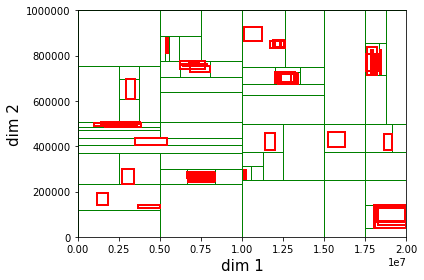

In [14]:
visualize_kdnodes_and_query_2(adk_kdnode, training_set, [], domains)